In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 125.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import tensorflow as tf
import pennylane as qml
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Principal Component Analysis (PCA) is applied to the MNIST dataset, which consists of 60,000 grayscale 28×28 images of handwritten digits. Each image is flattened into a 784-dimensional vector, and PCA is used to reduce its dimensionality while retaining 95% of the variance. The function determines that 154 principal components are sufficient to preserve this information, significantly reducing the data size while maintaining essential features for classification.

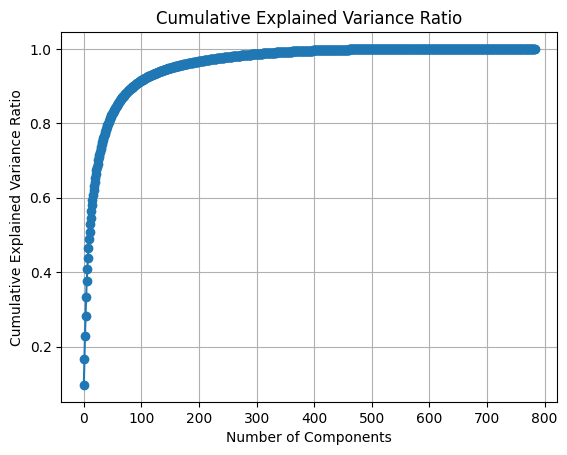

PCA Images: (60000, 154)


In [ ]:

# Apply PCA
def apply_pca_to_dataset(images, target_variance=0.95):
    """
    Apply PCA to the entire dataset.

    Parameters:
    - images: Array of images where each image is a 2D array.
    - target_variance: Target variance for PCA.

    Returns:
    - pca_images: Array of PCA-transformed images.
    """
    flattened_images = images.reshape(images.shape[0], -1)

    pca = PCA(n_components=None)
    pca.fit(flattened_images)

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= target_variance) + 1 if np.any(cumulative_variance >= target_variance) else len(cumulative_variance)

    plt.figure()
    plt.plot(cumulative_variance, marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Explained Variance Ratio')
    plt.grid(True)
    plt.show()

    pca = PCA(n_components=n_components)
    pca_images = pca.fit_transform(flattened_images)

    return pca_images


pca_images = apply_pca_to_dataset(x_train)
print("PCA Images:", pca_images.shape)


In [ ]:
(x_train, y_train) = (x_train[:100], y_train[:100])
x_train = x_train / 255.0

Max Pooling is applied to the MNIST dataset to reduce the spatial dimensions of the images. Initially, the training images (x_train) are expanded to have a channel dimension for compatibility with TensorFlow's MaxPooling2D layer. The Max Pooling layer is then applied with a 2×2 pool size and a stride of 2, effectively reducing each 28×28 image to 14×14, while retaining the most prominent pixel values in each region. Finally, the extra dimension added earlier is removed, restoring the array to its original format.

In [ ]:
# Max pooling to reduce image size
x_train = np.expand_dims(x_train, axis=-1)
max_pooling_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')
x_train = max_pooling_layer(x_train)
x_train = np.squeeze(x_train, axis=-1)

This quantum circuit embeds classical data using Amplitude Embedding on 8 qubits and applies parameterized rotations (qml.Rot) for feature encoding. It also introduces entanglement using CNOT gates between adjacent qubits to enhance expressivity.

In [ ]:
dev = qml.device('default.qubit', wires=17)  # One extra qubit for swap test

@qml.qnode(dev, interface="tf")
def circuit(features, weights):
    """Quantum Embedding Circuit"""
    qml.templates.AmplitudeEmbedding(features, wires=range(8), normalize=True, pad_with=0.)

    for i in range(tf.shape(weights)[0]):
        qml.Rot(*weights[i], wires=i)
        if i % 2 == 0:
            qml.CNOT(wires=[i, (i+1) % 8])
            qml.Rot(*weights[i], wires=(i+1) % 8)

    return qml.state()

# Performing SWAP Test

This quantum swap test circuit determines the similarity between two feature-encoded images by embedding them into two separate 8-qubit registers using Amplitude Embedding. A controlled SWAP (CSWAP) operation swaps corresponding qubits between the two registers, conditioned on an auxiliary qubit. The final Hadamard gate on the auxiliary qubit enables measurement, where the probability of measuring |0⟩ indicates the similarity between the two images.

# Initial Hadamard Superposition

The auxiliary qubit is initialized in |0⟩ and passed through a Hadamard gate, creating an equal superposition of |0⟩ and |1⟩:

$$
\frac{1}{\sqrt{2}} (|0\rangle + |1\rangle)
$$

# Embedding the Images

The two images (feature vectors features1 and features2) are embedded into two separate 8-qubit registers.

# Controlled SWAP (CSWAP) Operation

- If the auxiliary qubit is |1⟩, it swaps the corresponding qubits in both registers.
- If the auxiliary qubit is |0⟩, nothing changes.

# Final Hadamard and Measurement

After applying another Hadamard gate to the auxiliary qubit, the probability of measuring |0⟩ is:

$$
P(|0\rangle) = \frac{1 + |\langle \psi_1 | \psi_2 \rangle|^2}{2}
$$

where |⟨ψ₁ | ψ₂⟩|² represents the fidelity (or squared overlap) between the quantum states of the two images.

# Interpreting the Probability

- If features1 and features2 are identical, their states are the same (|ψ₁⟩ = |ψ₂⟩), so |⟨ψ₁ | ψ₂⟩|² = 1, giving P(|0⟩) = 1 (maximum probability).
- If they are completely different (orthogonal states), |⟨ψ₁ | ψ₂⟩|² = 0, giving P(|0⟩) = 0.5.
- Intermediate probabilities indicate partial similarity.


In [ ]:
@qml.qnode(dev, interface="tf")
def swap_test_circuit(features1, features2, weights):
    """Quantum Swap Test Circuit"""

    qml.Hadamard(wires=16)  # Auxiliary qubit

    # First image
    qml.templates.AmplitudeEmbedding(features1, wires=range(8), normalize=True, pad_with=0.)
    for i in range(tf.shape(weights)[0]):
        qml.Rot(*weights[i], wires=i)

    # Second image
    qml.templates.AmplitudeEmbedding(features2, wires=range(8, 16), normalize=True, pad_with=0.)
    for i in range(tf.shape(weights)[0]):
        qml.Rot(*weights[i], wires=i+8)

    # Controlled SWAP test
    for i in range(8):
        qml.CSWAP(wires=[16, i, i+8])

    qml.Hadamard(wires=16)  # Final Hadamard on auxiliary qubit
    return qml.probs(wires=16)

The quantum_fidelity function extracts similarity from the probability of measuring |1⟩, using:
 $$
   F = 1 - 2P(|1\rangle)
   $$

To optimize the quantum embeddings, a contrastive loss function is used. The contrastive loss function is designed for training a Siamese Network with quantum embeddings. It minimizes loss for similar pairs by squaring their similarity score and applies a margin-based penalty for dissimilar pairs, ensuring they are pushed apart in feature space.

   $$
   L = \frac{1}{2} \left[ y_{\text{true}} \cdot \text{similarity}^2 + (1 - y_{\text{true}}) \cdot \max(\text{margin} - \text{similarity}, 0)^2 \right]
   $$




   A Siamese Network is a type of neural network designed for pairwise comparisons. Instead of classifying inputs directly, it learns a similarity function that measures how close two inputs are in feature space. It consists of two identical sub-networks (hence the name Siamese), each processing one of the two inputs. The outputs of both networks are then compared using a similarity metric, such as Euclidean distance, cosine similarity, or contrastive loss.

In [ ]:
def quantum_embedding_model(features, weights):
    return circuit(features=features, weights=weights)


def quantum_fidelity(state1, state2, weights):
    """Compute Fidelity using Swap Test"""
    swap_test_result = swap_test_circuit(state1, state2, weights)
    fidelity = 1 - 2 * swap_test_result[1]
    return fidelity


# Contrastive loss function
def contrastive_loss(y_true, similarity, margin=1):
    loss_similar = y_true * tf.square(similarity)
    loss_dissimilar = (1 - y_true) * tf.square(tf.maximum(margin - similarity, 0))
    return tf.reduce_mean(0.5 * (loss_similar + loss_dissimilar))

Epoch 1, Loss: 0.1924
Epoch 2, Loss: 0.1900
Epoch 3, Loss: 0.1984
Epoch 4, Loss: 0.1966
Epoch 5, Loss: 0.1998
Epoch 6, Loss: 0.1910
Epoch 7, Loss: 0.1931
Epoch 8, Loss: 0.1969
Epoch 9, Loss: 0.1894
Epoch 10, Loss: 0.1970
Similarity score: 1.0 Label: 1


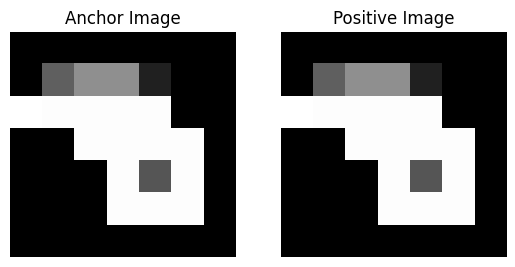

Similarity score: 0.28215905561256116 Label: 0


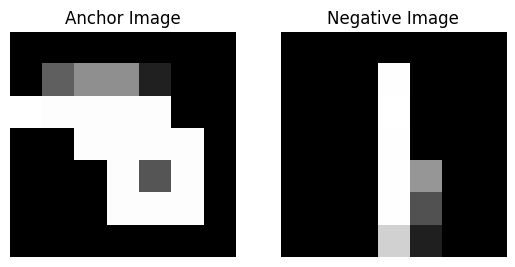

In [12]:
num_params = 8
sample_weights = np.random.randn(num_params, 3)
sample_weights_tf = tf.Variable(sample_weights, dtype=tf.float32)

# Training loop
num_epochs = 10
batch_size = 2
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)

for epoch in range(num_epochs):
    total_loss = 0
    num_batches = len(x_train) // batch_size

    for batch_idx in range(num_batches):
        positive_pairs = []
        negative_pairs = []
        labels = []

        for i in range(batch_size):
            anchor_image = x_train[np.random.randint(0, len(x_train))]

            positive_image = anchor_image
            negative_image = x_train[np.random.randint(0, len(x_train))]
            while np.array_equal(negative_image, anchor_image):
                negative_image = x_train[np.random.randint(0, len(x_train))]

            positive_pairs.append((anchor_image, positive_image))
            negative_pairs.append((anchor_image, negative_image))
            labels.append(1)
            labels.append(0)

        # Embeddings and similarity scores using Swap Test
        positive_similarities = []
        for pair in positive_pairs:
            pair0 = tf.reshape(pair[0], -1)
            pair1 = tf.reshape(pair[1], -1)
            similarity = quantum_fidelity(pair0, pair1, sample_weights_tf)
            positive_similarities.append(similarity)

        negative_similarities = []
        for pair in negative_pairs:
            pair0 = tf.reshape(pair[0], -1)
            pair1 = tf.reshape(pair[1], -1)
            similarity = quantum_fidelity(pair0, pair1, sample_weights_tf)
            negative_similarities.append(similarity)

        all_similarities = positive_similarities + negative_similarities

        all_similarities_tf = tf.convert_to_tensor(all_similarities, dtype=tf.float32)
        labels_tf = tf.convert_to_tensor(labels, dtype=tf.float32)

        with tf.GradientTape() as tape:
            loss = contrastive_loss(labels_tf, all_similarities_tf, margin=1)



        total_loss += loss.numpy()

    print("Epoch {}, Loss: {:.4f}".format(epoch + 1, total_loss / num_batches))


# Evaluation
def evaluate_model(model, x_eval, num_pairs=2):
    positive_pairs = []
    negative_pairs = []
    labels = []

    anchor_image = x_train[np.random.randint(0, len(x_train))]
    positive_image = anchor_image
    negative_image = x_train[np.random.randint(0, len(x_train))]
    while np.array_equal(negative_image, anchor_image):
        negative_image = x_train[np.random.randint(0, len(x_train))]

    positive_pairs.append((anchor_image, positive_image))
    negative_pairs.append((anchor_image, negative_image))
    labels.append(1)
    labels.append(0)

    for pair in positive_pairs:
        pair0 = tf.reshape(pair[0], -1)
        pair1 = tf.reshape(pair[1], -1)
        similarity = quantum_fidelity(pair0, pair1, sample_weights_tf)
        print("Similarity score:", similarity.numpy(), "Label: 1")
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(pair[0], cmap='gray')
        plt.title("Anchor Image")
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(pair[1], cmap='gray')
        plt.title("Positive Image")
        plt.axis('off')
        plt.show()

    for pair in negative_pairs:
        pair0 = tf.reshape(pair[0], -1)
        pair1 = tf.reshape(pair[1], -1)
        similarity = quantum_fidelity(pair0, pair1, sample_weights_tf)
        print("Similarity score:", similarity.numpy(), "Label: 0")
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(pair[0], cmap='gray')
        plt.title("Anchor Image")
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(pair[1], cmap='gray')
        plt.title("Negative Image")
        plt.axis('off')
        plt.show()


evaluate_model(quantum_embedding_model, x_train)


Similarity score: 1.0 Label: 1


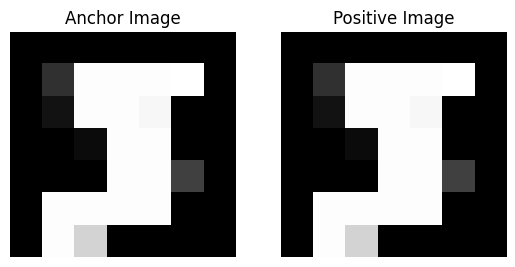

Similarity score: 1.0 Label: 1


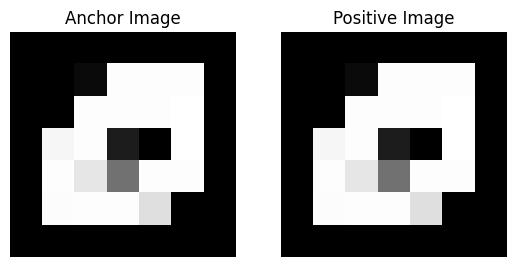

Similarity score: 1.0 Label: 1


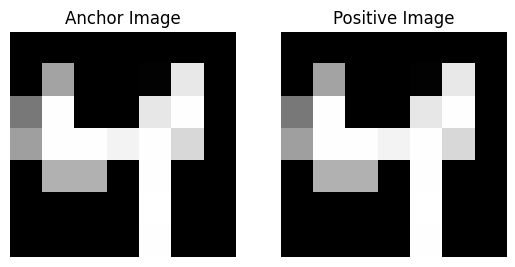

Similarity score: 0.46322016285738077 Label: 0


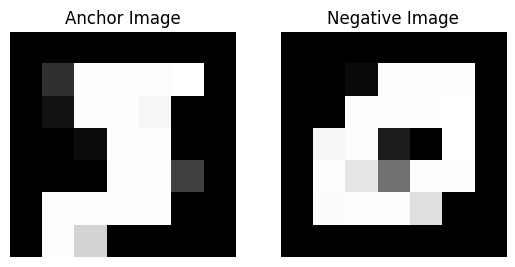

Similarity score: 0.3413774504983058 Label: 0


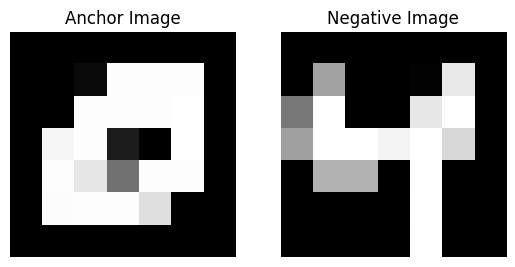

Similarity score: 0.1525904184719048 Label: 0


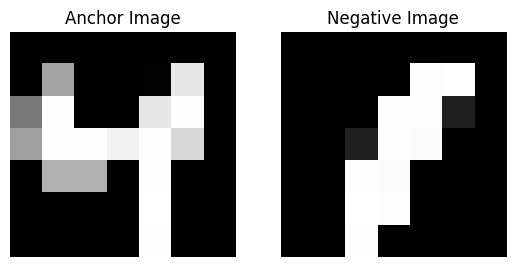

In [13]:
# Evaluating for 3 other pairs
def evaluate_model(model, x_eval, num_pairs=3):
    positive_pairs = []
    negative_pairs = []
    labels = []

    for i in range(num_pairs):
        anchor_image = x_eval[i]
        positive_image = anchor_image
        negative_image = x_eval[(i+1) % len(x_eval)]

        positive_pairs.append((anchor_image, positive_image))
        negative_pairs.append((anchor_image, negative_image))
        labels.append(1)
        labels.append(0)

    for pair in positive_pairs:
        pair0 = tf.reshape(pair[0], -1)
        pair1 = tf.reshape(pair[1], -1)
        similarity = quantum_fidelity(pair0, pair1, sample_weights_tf)
        print("Similarity score:", similarity.numpy(), "Label: 1")
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(pair[0], cmap='gray')
        plt.title("Anchor Image")
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(pair[1], cmap='gray')
        plt.title("Positive Image")
        plt.axis('off')
        plt.show()

    for pair in negative_pairs:
        pair0 = tf.reshape(pair[0], -1)
        pair1 = tf.reshape(pair[1], -1)
        similarity = quantum_fidelity(pair0, pair1, sample_weights_tf)
        print("Similarity score:", similarity.numpy(), "Label: 0")
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(pair[0], cmap='gray')
        plt.title("Anchor Image")
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(pair[1], cmap='gray')
        plt.title("Negative Image")
        plt.axis('off')
        plt.show()


evaluate_model(quantum_embedding_model, x_train)


# Using a Quantum Fidelity Function to calculate fidelity between two quantum states

In [ ]:
@qml.qnode(dev, interface="tf")
def circuit(features, weights):
    qml.templates.AmplitudeEmbedding(features, wires=range(8), normalize=True, pad_with=0.)

    for i in range(tf.shape(weights)[0]):
        qml.Rot(*weights[i], wires=i)
        if i % 2 == 0:
            qml.CNOT(wires=[i, (i+1) % 8])
            qml.Rot(*weights[i], wires=(i+1) % 8)

    return qml.expval(qml.Z(0)), qml.state()

In [ ]:
def quantum_embedding_model(features, weights):
    res, state = circuit(features=features, weights=weights)
    return state


The quantum_fidelity function computes the similarity between two quantum states, ensuring the fidelity value remains within the valid range [0,1].

In [ ]:
# Function to calculate fidelity between two quantum states
def quantum_fidelity(state1, state2):
    fidelity = qml.math.fidelity_statevector(state1, state2)
    if fidelity > 1:
        fidelity = 1
    if fidelity < 0:
        fidelity = 0
    return fidelity

# Contrastive loss function
def contrastive_loss(y_true, similarity, margin=1):
    loss_similar = y_true * tf.square(similarity)
    loss_dissimilar = (1 - y_true) * tf.square(tf.maximum(margin - similarity, 0))
    return tf.reduce_mean(0.5 * (loss_similar + loss_dissimilar))

Epoch 1, Loss: 0.2083
Epoch 2, Loss: 0.2041
Epoch 3, Loss: 0.2017
Epoch 4, Loss: 0.1993
Epoch 5, Loss: 0.2016
Epoch 6, Loss: 0.2069
Epoch 7, Loss: 0.2038
Epoch 8, Loss: 0.1988
Epoch 9, Loss: 0.1948
Epoch 10, Loss: 0.1991
Similarity score: 1 Label: 1


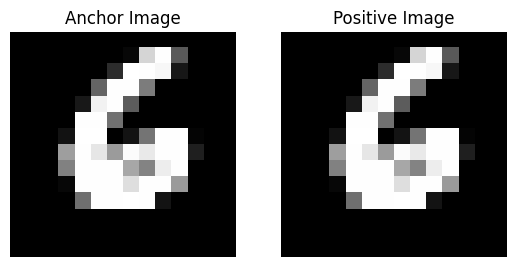

Similarity score: tf.Tensor(0.3980853055212184, shape=(), dtype=float64) Label: 0


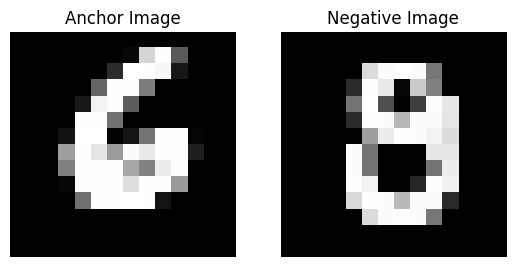

Similarity score (positive): 1
Similarity score (negative): tf.Tensor(0.4620064558610217, shape=(), dtype=float64)


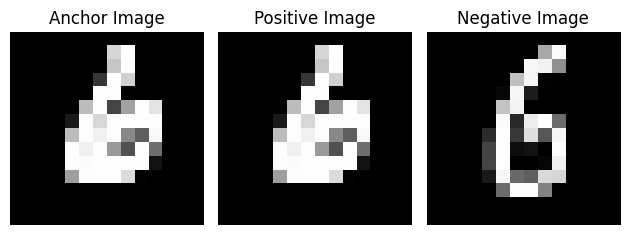

Similarity score (positive): 1
Similarity score (negative): tf.Tensor(0.37946426038549824, shape=(), dtype=float64)


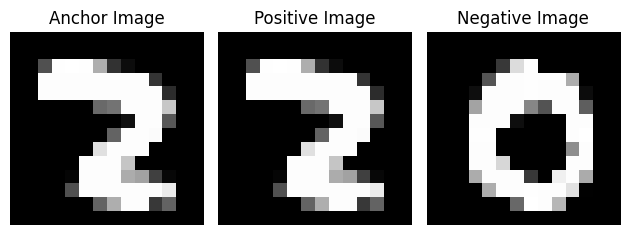

Similarity score (positive): 1
Similarity score (negative): tf.Tensor(0.32698715913027093, shape=(), dtype=float64)


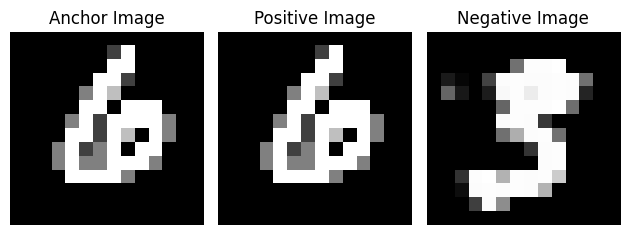

In [ ]:
num_params = 8
sample_weights = np.random.randn(num_params, 3)
sample_weights_tf = tf.Variable(sample_weights, dtype=tf.float32)

# Training loop
num_epochs = 10
batch_size = 2
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)

for epoch in range(num_epochs):
    total_loss = 0
    num_batches = len(x_train) // batch_size

    for batch_idx in range(num_batches):
        positive_pairs = []
        negative_pairs = []
        labels = []

        for i in range(batch_size):
            anchor_image = x_train[np.random.randint(0, len(x_train))]

            # Positive pair (similar image)
            positive_image = anchor_image

            # Negative pair (dissimilar image)
            negative_image = x_train[np.random.randint(0, len(x_train))]
            while np.array_equal(negative_image, anchor_image):
                negative_image = x_train[np.random.randint(0, len(x_train))]

            positive_pairs.append((anchor_image, positive_image))
            negative_pairs.append((anchor_image, negative_image))
            labels.append(1)
            labels.append(0)

        # Embeddings and similarity scores for positive pairs
        positive_similarities = []
        for pair in positive_pairs:
            pair0 = tf.reshape(pair[0], -1)
            pair1 = tf.reshape(pair[1], -1)
            anchor_embedding = quantum_embedding_model(features=pair0, weights=sample_weights_tf)
            positive_embedding = quantum_embedding_model(features=pair1, weights=sample_weights_tf)
            similarity = quantum_fidelity(anchor_embedding, positive_embedding)
            positive_similarities.append(similarity)

        # Embeddings and similarity scores for negative pairs
        negative_similarities = []
        for pair in negative_pairs:
            pair0 = tf.reshape(pair[0], -1)
            pair1 = tf.reshape(pair[1], -1)
            anchor_embedding = quantum_embedding_model(features=pair0, weights=sample_weights_tf)
            negative_embedding = quantum_embedding_model(features=pair1, weights=sample_weights_tf)
            similarity = quantum_fidelity(anchor_embedding, negative_embedding)
            negative_similarities.append(similarity)

        # Concatenate
        all_similarities = positive_similarities + negative_similarities
        all_similarities_tf = tf.convert_to_tensor(all_similarities, dtype=tf.float32)
        labels_tf = tf.convert_to_tensor(labels, dtype=tf.float32)

        with tf.GradientTape() as tape:
            loss = contrastive_loss(labels_tf, all_similarities_tf, margin=1)

        gradients = tape.gradient(loss, sample_weights_tf)

        total_loss += loss.numpy()

    print("Epoch {}, Loss: {:.4f}".format(epoch + 1, total_loss / num_batches))

# Evaluation
def evaluate_model(model, x_eval, num_pairs=2):
    positive_pairs = []
    negative_pairs = []
    labels = []

    anchor_image = x_train[np.random.randint(0, len(x_train))]

    # Positive pair (similar image)
    positive_image = anchor_image

    # Negative pair (dissimilar image)
    negative_image = x_train[np.random.randint(0, len(x_train))]
    while np.array_equal(negative_image, anchor_image):
        negative_image = x_train[np.random.randint(0, len(x_train))]

    positive_pairs.append((anchor_image, positive_image))
    negative_pairs.append((anchor_image, negative_image))
    labels.append(1)
    labels.append(0)

    for pair in positive_pairs:
        pair0 = tf.reshape(pair[0], -1)
        pair1 = tf.reshape(pair[1], -1)
        anchor_embedding = quantum_embedding_model(features=pair0, weights=sample_weights_tf)
        positive_embedding = quantum_embedding_model(features=pair1, weights=sample_weights_tf)
        similarity = quantum_fidelity(anchor_embedding, positive_embedding)
        print("Similarity score:", similarity, "Label: 1")
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(pair[0], cmap='gray')
        plt.title("Anchor Image")
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(pair[1], cmap='gray')
        plt.title("Positive Image")
        plt.axis('off')
        plt.show()

    # Embeddings and similarity scores for negative pairs
    for pair in negative_pairs:
        pair0 = tf.reshape(pair[0], -1)
        pair1 = tf.reshape(pair[1], -1)
        anchor_embedding = quantum_embedding_model(features=pair0, weights=sample_weights_tf)
        negative_embedding = quantum_embedding_model(features=pair1, weights=sample_weights_tf)
        similarity = quantum_fidelity(anchor_embedding, negative_embedding)
        print("Similarity score:", similarity, "Label: 0")
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(pair[0], cmap='gray')
        plt.title("Anchor Image")
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(pair[1], cmap='gray')
        plt.title("Negative Image")
        plt.axis('off')
        plt.show()

evaluate_model(quantum_embedding_model, x_train)



#Evaluating for three more pairs
for i in range(3):
    anchor_image = x_train[np.random.randint(0, len(x_train))]
    positive_image = anchor_image
    negative_image = x_train[np.random.randint(0, len(x_train))]
    while np.array_equal(negative_image, anchor_image):
        negative_image = x_train[np.random.randint(0, len(x_train))]

    pair0 = tf.reshape(anchor_image, -1)
    pair1 = tf.reshape(positive_image, -1)
    anchor_embedding = quantum_embedding_model(features=pair0, weights=sample_weights_tf)
    positive_embedding = quantum_embedding_model(features=pair1, weights=sample_weights_tf)
    similarity = quantum_fidelity(anchor_embedding, positive_embedding)
    print("Similarity score (positive):", similarity)

    pair0 = tf.reshape(anchor_image, -1)
    pair1 = tf.reshape(negative_image, -1)
    anchor_embedding = quantum_embedding_model(features=pair0, weights=sample_weights_tf)
    negative_embedding = quantum_embedding_model(features=pair1, weights=sample_weights_tf)
    similarity = quantum_fidelity(anchor_embedding, negative_embedding)
    print("Similarity score (negative):", similarity)

    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(anchor_image, cmap='gray')
    plt.title("Anchor Image")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(positive_image, cmap='gray')
    plt.title("Positive Image")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(negative_image, cmap='gray')
    plt.title("Negative Image")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
